# PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões
Análise e classificação com a base de dados [Adult](https://www.kaggle.com/c/adult-pmr3508), disponível também em [UCI Repository](https://archive.ics.uci.edu/ml/index.php).

Autor: Lucas Tonini Rosenberg Schneider

---

## Sumário

- [1 Iniciatlização](#inicializacao)
    - [1.1 Importando pacotes necessários](#importando)
    - [1.2 Leitura de dados](#leitura)
- [2 Análise e compreensão](#analise)
    - [2.1 Dados numéricos](#analise-num)
    - [2.2 Dados categóricos](#analise-cat)
- [3 Preparação dos dados](#prep)
    - [3.1 Dados faltantes](#missing)
    - [3.2 Tratamento de features](#features)
- [4 Modelo](#modelo)
- [5 Conclusão](#conclusao)


---
<a id="inicializacao"></a>
## 1 Inicialização

<a id="importando"></a>
### 1.1 Importando pacotes necessários

Primeiramente, vamos instalar os pacotes seaborn e statsmodels na versão necessária para evitar problemas de compatibilidade das versões mais recentes. Em seguida, importaremos todos os pacotes que serão necessários durante as fases de análise, tratamento e treinamento.

In [1]:
!pip install seaborn==0.9.0
!pip install statsmodels==0.10.1

     |████████████████████████████████| 208 kB 195 kB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

hypertools 0.6.2 requires scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.23.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 8.1 MB 2.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.11.1
    Uninstalling statsmodels-0.11.1:
      Successfully uninstalled statsmodels-0.11.1
ERROR: After October 2020 you may experie

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing as prep

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a id="leitura"></a>
### 1.2 Leitura dos dados

In [3]:
x_columns = ['ID', 'Age', 'Workclass', 'Final Weight', 'Education', 'Education Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per Week', 'Native Country']
y_column = ['Income']

train_data_raw = pd.read_csv('data/train_data.csv', names = (x_columns + y_column), na_values = '?', header = 0)
test_data_raw = pd.read_csv('data/test_data.csv', names = x_columns, na_values = '?', header = 0)

In [4]:
print(train_data_raw.shape)
train_data_raw.head()

(32560, 16)


,ID,Age,Workclass,Final Weight,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country,Income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


---
<a id="analise"></a>
## 2 Análise e compreensão

Antes de tudo, é importante visualizar melhor os dados disponíveis para um melhor entendimento do problema. A seguir, faremos isso separadamnete para os dados numéricos e categóricos.

<a id="analise-num"></a>
### 2.1 Dados Numéricos

In [5]:
numeric_columns = list(train_data_raw.select_dtypes(include = np.number).columns)
train_data_raw[numeric_columns].describe()

,ID,Age,Final Weight,Education Num,Capital Gain,Capital Loss,Hours per Week
count,32560.000000,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,32559.500000,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,9399.406719,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,16280.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,24419.750000,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,32559.500000,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,40699.250000,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,48839.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


A feature ID contém apenas um número de identificação, ou seja, não é uma informação que faça sentido analisar, e, por isso, será removida durante o tratamento dos dados.
Em seguida, criaremos um DataFrame apenas com os dados numéricos e o Income para melhor visualização.

In [6]:
numeric_columns.remove('ID')

view_num_df = train_data_raw[numeric_columns].copy()
for column in numeric_columns:
    view_num_df[column] = pd.to_numeric(view_num_df[column])
    
view_num_df['Income'] = train_data_raw['Income']

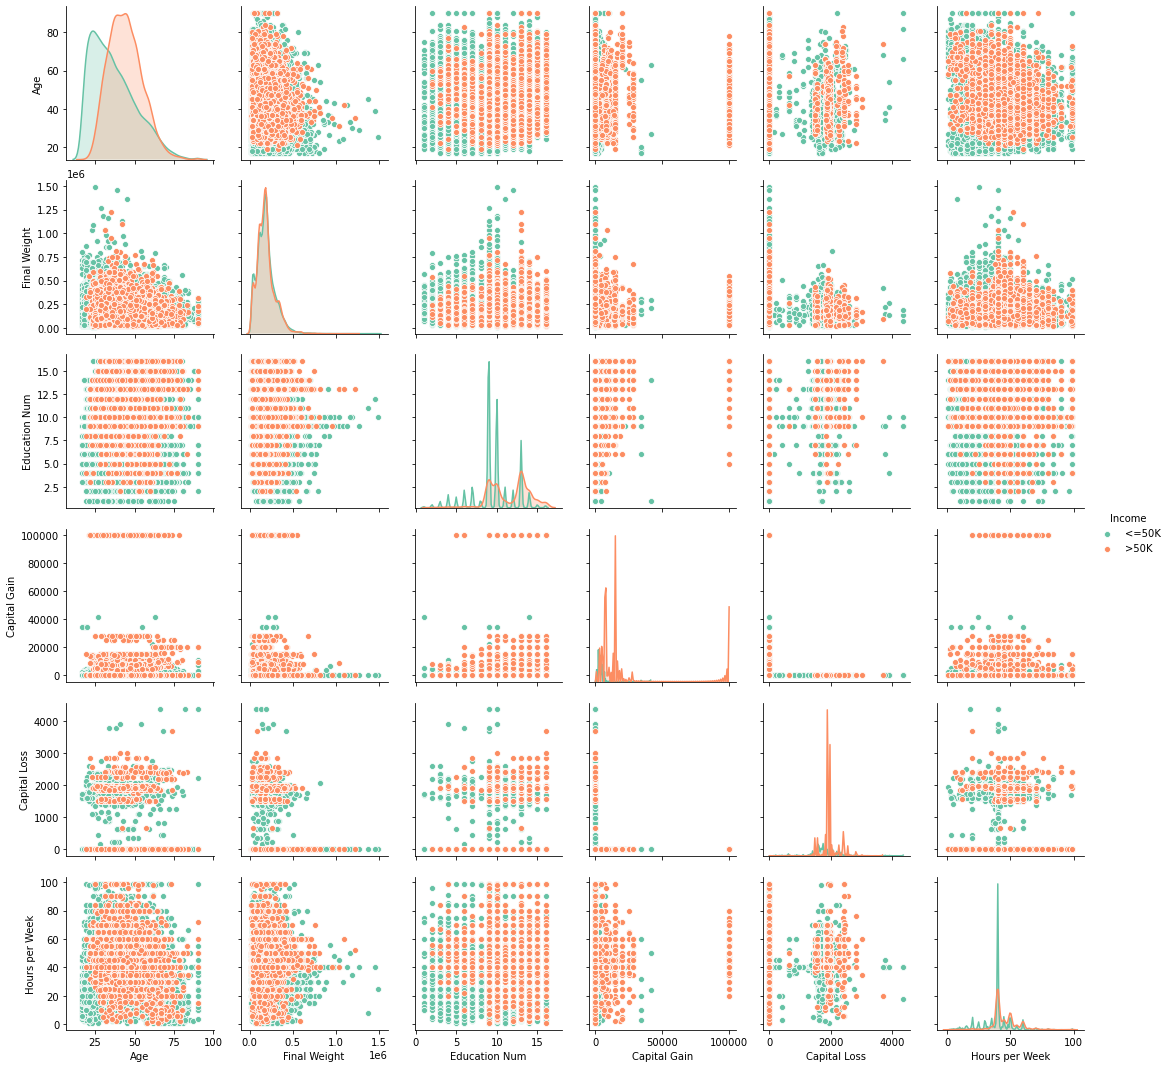

In [7]:
pp_graph = sns.pairplot(view_num_df, hue="Income", palette="Set2", diag_kind="kde", height=2.5)

Vamos primeiro analisar a diagonal principal, que fornece uma aproximação da distribuição de densidade para cada uma das variáveis numéricas. A primeira coisa a se notar é como as curvas de Final Weight são praticamente iguais. Essa variável não parece ajudar muito a diferenciar a renda das pessoas. Por outro lado, Age, Education Num e Hours per Week mostram variações mais significativas para cada classe observada, e devem ser úteis para o classificador.

Analisando agora os gráficos fora da diagonal principal, pode-se perceber que a correlação entre as variáveis não parece ser muito alta, já que  todos eles parecem possuir pontos bem dispersos. Além disso, novamente os gráficos de correlação entre Age, Education Num e Hours per Week parecem fronecer limites mais claros para regiões onde o Income é predominantemente maior ou menor que 50k.

Por fim, uma última observação que pode-se fazer é que, independente de outras variáveis, indivíduos com Capital Gain ou com Capital Loss nulo tendem a possuir um Income >50k.

In [8]:
def plot_feature_frequencies(data, feature, kind='line'):
    '''
    Plot frequencie for income <=50k and >50k for a specific feature
    '''
    
    less_50 = data.loc[data['Income'] == '<=50K', feature].value_counts().rename('<=50K')
    more_50 = data.loc[data['Income'] == '>50K', feature].value_counts().rename('>50K')
    plot_data = pd.concat([less_50, more_50], axis=1)
    plot_data.plot(xlabel = feature, ylabel = 'Frequency', kind=kind)
    return plot_data

Vamos plotar agora os gráficos com a frequência aboluta das 3 variáveis que pareceram mais relevante a partir da análise anterior.

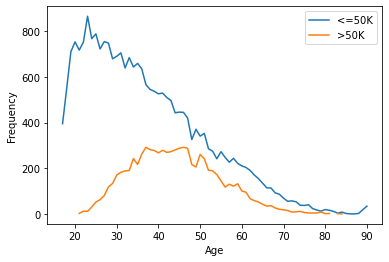

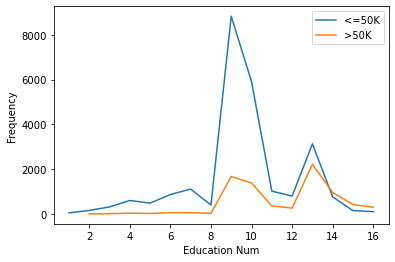

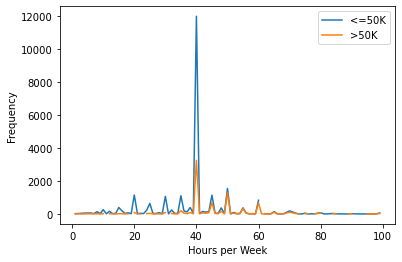

In [9]:
for feature in ['Age', 'Education Num', 'Hours per Week']:
    plot_feature_frequencies(view_num_df, feature)

É possível ver claramente como a proporção de pessoas que ganham mais que 50 mil aumenta drásticamente com a idade. Entre 20 e 40 anos, há um crescimento acelerado, e a partir daí, a proporção se mantém mais estável.

Em relação ao Education Number, todos os indivíduos que ganhavam mais que 50k tem nível de escolaridade maior que 8, ou seja, pelo menos um diploma no nível técnico. Além disso, apenas a partir do nível 14, ou seja, a partir do bacharelado, a proporção de indivíduos que ganahvam mais que 50k superou a dos que ganahvam menos. Logo, grau de escolaridade seria um fator importante para fazer predições em relação à renda.

Por fim, em Hours per Week, percebe-se claramente que a maior parte das pessoas possui a jornada padrão de 40h por semana. Porém, quanto mais aumenta-se o número de horas trabalhadas, maior é a proporção de pessoas que ganham mais que 50k, enquanto para valores menores que 40h, a quantidade é bem pequena.

<a id="analise-cat"></a>
### 2.2 Dados categóricos

In [10]:
categoric_columns = list(train_data_raw.select_dtypes(exclude = np.number).columns)
train_data_raw[categoric_columns].describe()

,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Native Country,Income
count,30724,32560,32560,30717,32560,32560,32560,31977,32560
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


Vamos remover a coluna de Education, pois a mesma análise já foi feita para Education Num, e, novamente, criaremos um novo DataFrame para facilitar a visualização.

In [11]:
categoric_columns.remove('Education')
view_cat_df = train_data_raw[categoric_columns].copy()

,<=50K,>50K
Private,17733,4963.0
Self-emp-not-inc,1817,724.0
Local-gov,1476,617.0
State-gov,944,353.0
Federal-gov,589,371.0


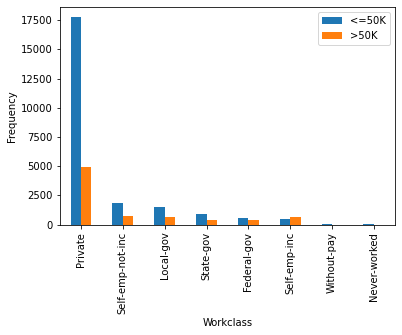

In [12]:
plot_feature_frequencies(view_cat_df, 'Workclass', 'bar').head()

Aqui pode-se perceber um leve desbalanceamento, pois a maior parte dos indicíduos trabalha no setor privado. Mesmo assim, é interessante notar como a única categoria em que a proporção dos índividuos que recebem mais que 50k é maior que os que recebem menos é a de "Incorporated self employment".

,<=50K,>50K
Adm-clerical,3262,507
Craft-repair,3170,929
Other-service,3158,137
Sales,2667,983
Prof-specialty,2281,1859


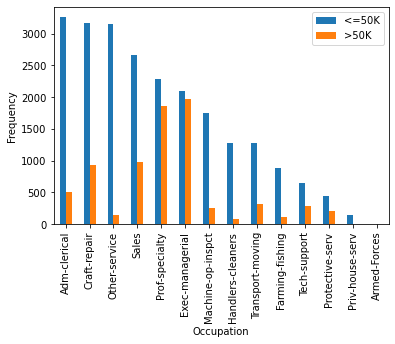

In [13]:
plot_feature_frequencies(view_cat_df, 'Occupation', 'bar').head()

Nesse exemplo, as ocupações que recebem mais pretígio social estão diretamente relacionadas com uma maior renda, como é o caso de Prof especialista e gerente executivo.

,<=50K,>50K
Never-married,10191,491
Married-civ-spouse,8284,6692
Divorced,3980,463
Separated,959,66
Widowed,908,85


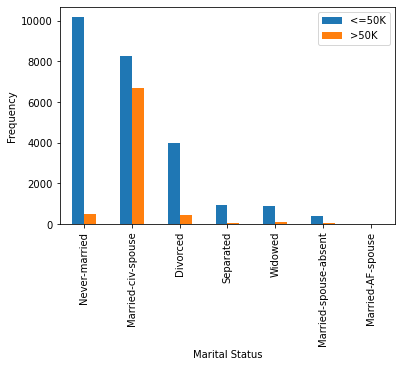

In [14]:
plot_feature_frequencies(view_cat_df, 'Marital Status', 'bar').head()

Nesse exemplo é interessante notar como o fato de estar casado e vivendo com o(a) parceiro(a) tem grande relação com a renda. A única categoria em que os indivíduos com Income maior q 50k possuem representação relevante é a de casado com parceiro civil, por isso, talvez seja interessante construir uma feature que represente exatamente essa situação.

,<=50K,>50K
Not-in-family,7448,856
Husband,7275,5918
Own-child,5001,67
Unmarried,3228,218
Other-relative,944,37


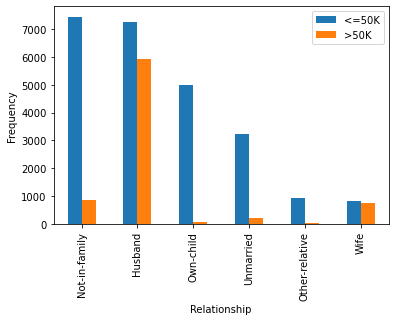

In [15]:
plot_feature_frequencies(view_cat_df, 'Relationship', 'bar').head()

Aqui, a questão de casamento se apresenta novamente, com as proporções de renda maior que 50k bem equilibradas para maridos e esposas, enquanto para os outros tipos de relacionamento, a quantidade de indivíduos com renda alta é bem menor.

,<=50K,>50K
Male,15127,6662
Female,9592,1179


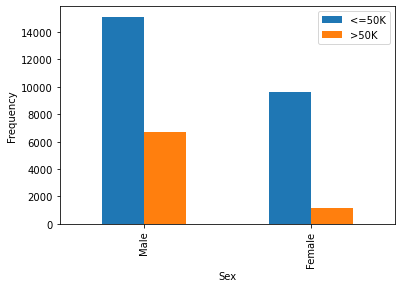

In [16]:
plot_feature_frequencies(view_cat_df, 'Sex', 'bar').head()

Com esse gráfico, a grande diferença entre a renda das mulheres e dos homens fica bem clara. Isso só comprova a diferença salarial e de oportunidades para as mulheres causada pelo machismo da sociedade contemporânea.

,<=50K,>50K
White,20698,7117
Black,2737,387
Asian-Pac-Islander,763,276
Amer-Indian-Eskimo,275,36
Other,246,25


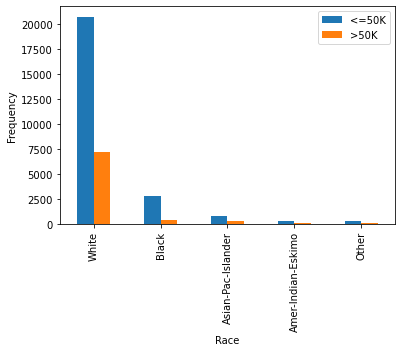

In [17]:
plot_feature_frequencies(view_cat_df, 'Race', 'bar').head()

Aqui, a questão do racismo fica evidente, pois pelos dados, aproximadamente 25% da população branca teria renda maior que 50k, enquanto para a população negra, esse número cai para 12%. Outro fator importante é que a população hipânica não parece ter sido representada nessa pesquisa, mesmo compondo aproximadamente 15,4% da população americana, ou seja, é a segunda etnia mais representativa dos EUA (dados de 2008).

,<=50K,>50K
United-States,21998,7171.0
Mexico,610,33.0
Philippines,137,61.0
Puerto-Rico,102,12.0
El-Salvador,97,9.0


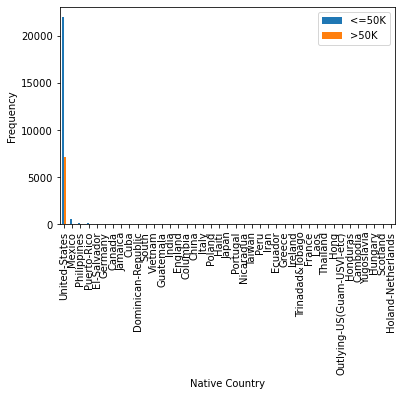

In [18]:
plot_feature_frequencies(view_cat_df, 'Native Country', 'bar').head()

Em relação ao país de origem, há um desbalanceamento extremo, que pode ser claramente visto pelo gráfico. Dessa forma, a alternativa escolhida para lidar com esse problema será não utilizar esses dados.

---
<a id="prep"></a>
## 3 Preparação dos dados

<a id="missing"></a>
### 3.1 Dados faltantes

In [19]:
def count_missing_values(data):
    '''
    Count missing values for each feature and return a sorted DataFrame with the resuls
    '''

    missing_count = []
    for column in data.columns:
        missing_count.append(data[column].isna().sum())
    missing_count = np.asarray(missing_count)
    missing_count = pd.DataFrame({'feature': data.columns, 'count': missing_count,
                                'freq. [%]': 100*missing_count/data.shape[0]}, index=None)
    missing_count.sort_values('count', ascending=False, inplace=True, ignore_index=True)
    return missing_count

In [20]:
display(count_missing_values(train_data_raw).head())
display(count_missing_values(test_data_raw).head())

,feature,count,freq. [%]
0,Occupation,1843,5.660319
1,Workclass,1836,5.638821
2,Native Country,583,1.790541
3,ID,0,0.000000
4,Age,0,0.000000


,feature,count,freq. [%]
0,Occupation,966,5.933661
1,Workclass,963,5.915233
2,Native Country,274,1.683047
3,ID,0,0.000000
4,Age,0,0.000000


Como pode-se perceber, as únicas variáveis que possuem dados faltantes, tanto na base de treino quanto de testes, são Occupation, Workclass e Native Country. Assim, vamos usar a função a seguir para imputar valores nessas variáveis.

In [21]:
def handle_missing_values(original_data, fill_options = None, drop_rest = False):
    '''
    Choose what to do with the missing values.
    fill_options is a dictionary where de features are keys, and the values are how to fill the missing data,
    the options are: unknown (fill with 'unknown'), mean (complete with the mean value), most_frequent (complete with most frequent value).
    The rest of the missing data will be dropped.
    '''

    data = original_data.copy()
    if fill_options is not None:
        for feature, action in fill_options.items():
            # print(feature, action)
            if feature not in data.columns:
                # print(feature)
                continue
            if action == 'unknown':
                data[feature].fillna('unknown', inplace=True)
            elif action == 'mean':
                data[feature].fillna(data[feature].mean(), inplace=True)
            elif action == 'most_frequent':
                top = data[feature].describe().top
                data[feature].fillna(top, inplace=True)
                
    data.dropna()

    return data


<a id="features"></a>

### 3.2 Tratamento de features

Aqui, useremos a função que trata os dados faltantes, além de outros métodos úteis, para preparar as bases de treino e teste.

Para isso, vamos selecionar as features relevantes, depois codificar as variáveis categóricas, e por fim, gerar X_test, X_train e Y_train para nosso classificador.

In [22]:
def data_pipeline(train_raw, test_raw, fill_options = None, drop_columns = ['ID', 'Education']):
    '''
    Prepare the data to be used in the classifier
    '''

    train_data = train_raw.copy()
    test_data = test_raw.copy()

    # Remove duplicate itens from training data
    train_data.drop_duplicates(keep='first', inplace=True)
    
    # Remove unwanted columns
    if drop_columns is not None:
        train_data.drop(drop_columns, axis = 1, inplace=True)
        test_data.drop(drop_columns, axis = 1, inplace=True)

    # Handle the missing values
    train_data = handle_missing_values(train_data, fill_options, drop_rest=True)
    test_data = handle_missing_values(test_data, fill_options)

    # Separate columns types
    numeric_columns = list(test_data.select_dtypes(include = np.number).columns)
    categoric_columns = list(test_data.select_dtypes(exclude = np.number).columns)
    label_column = 'Income'

    # Apply scaler to numeric features
    scaler = prep.RobustScaler()
    scaler.fit(train_data[numeric_columns])
    train_num = scaler.transform(train_data[numeric_columns])
    test_num = scaler.transform(test_data[numeric_columns])

    # Encode the categoric feature into One Hot
    cat_encoder = prep.OneHotEncoder(sparse=False)
    cat_encoder.fit(train_data[categoric_columns])
    train_cat = cat_encoder.transform(train_data[categoric_columns])
    test_cat = cat_encoder.transform(test_data[categoric_columns])

    # Concatenate X arrays
    X_train = np.concatenate((train_num, train_cat), axis=1)
    X_test = np.concatenate((test_num, test_cat), axis=1)

    # Encode the labels
    label_encoder = prep.LabelEncoder()
    Y_train = label_encoder.fit_transform(train_data[label_column])
    
    # Make sure the test and train data have the same number of features
    assert X_train.shape[1] == X_test.shape[1]
    
    # Make sure the train data has the same number of examples in X and Y
    assert X_train.shape[0] == Y_train.shape[0]

    return X_train, Y_train, X_test, label_encoder

Para gerar nossos dados em bases X e Y, precisamos primeiro escolher o método para imputar os dados faltantes. Nesse caso, utilizaremos uma nova classe: 'unknown' como classe significativa para Occupation e Workclass.

Além disso, precisamos decidir quais features serão utilizadas no classificador. Já foi discutido previamente que ID e Education serão removidos. Além disso, optei por retirar Final Weight, que não tinham muita correlação com o Income, e Native Country, cujos dados estavam muito desbalanceados.

In [23]:
fill_options = {'Occupation': 'unknown', 'Workclass': 'unknown'}
drop_columns = ['ID', 'Education', 'Final Weight', 'Native Country']
X_train, Y_train, X_test, label_encoder = data_pipeline(train_data_raw, test_data_raw, fill_options, drop_columns)

In [24]:
print(f'X_train tem shape: {X_train.shape}')
print(f'Y_train tem shape: {Y_train.shape}')
print(f'X_test tem shape: {X_test.shape}')

X_train tem shape: (32560, 49)
Y_train tem shape: (32560,)
X_test tem shape: (16280, 49)


---
<a id="modelo"></a>
## 4 Modelo

O modelo utilizado nas predições do Income é o KNN (K-Nearest Neighbors), estudado em sala. Para treiná-lo, é preciso fazer algumas escolhas de hiperparâmetros, sendo que duas das principais são o número de vizinhos (k), e a métrica utilizada para cálculo da distância (normalmente a \\(L_2\\) ou euclidiana)

Para começar a escolha desses hiperparâmetros, testei com alguns valores de números de vizinhos com diferentes métricas. A seguir, vamos visualizar alguns resultados usando a distância de Minkowski com \\(p = 1\\), que corresponde à métrica \\(L_1\\) ou Manhattan, para vários valores de k.

In [25]:
for k_value in range(5, 45, 5):
    clf = KNeighborsClassifier(k_value, p=1, weights='uniform', n_jobs=-1)
    score = np.mean(cross_val_score(clf, X_train, Y_train, cv=10))
    
    print(f'Para {k_value} vizinhos, a acurácia foi de {100*score:.5f}%')

Para 5 vizinhos, a acurácia foi de 85.44840%
Para 10 vizinhos, a acurácia foi de 86.31143%
Para 15 vizinhos, a acurácia foi de 86.48649%
Para 20 vizinhos, a acurácia foi de 86.57248%
Para 25 vizinhos, a acurácia foi de 86.67998%
Para 30 vizinhos, a acurácia foi de 86.69226%
Para 35 vizinhos, a acurácia foi de 86.59705%
Para 40 vizinhos, a acurácia foi de 86.53563%


A partir dos resultados preliminares obtidos a cima, vamos agora procurar ao redor dos valores mais promissores, e escolher o classificador cujo número de vizinhos fornece a maior acurácia.

In [26]:
max_k = 0
max_score = 0.
knn_clf = None

for k_value in range(20, 35):
    clf = KNeighborsClassifier(k_value, p=1, weights='uniform', n_jobs=-1)
    score = np.mean(cross_val_score(clf, X_train, Y_train, cv=10))
    
    if score > max_score:
        max_score = score
        max_k = k_value
        knn_clf = clf
    
print(f'O melhor número de vizinhos encontrado foi {max_k}, com acurácia de {max_score*100:.5f}%')

O melhor número de vizinhos encontrado foi 28, com acurácia de 86.72297%


Utilizando o modelo selecionado anteriormente, vamos treiná-lo e fazer nossas predições.

In [27]:
knn_clf.fit(X_train, Y_train)
Y_hat_test = knn_clf.predict(X_test)
Y_hat_test = label_encoder.inverse_transform(Y_hat_test)

In [28]:
result_data = pd.DataFrame({'income': Y_hat_test})
display(result_data.head())
result_data.to_csv('submission.csv', index = True, index_label = 'Id')

,income
0,<=50K
1,>50K
2,<=50K
3,<=50K
4,>50K


---
<a id="conclusao"></a>
## 5 Conclusão

Apesar de ser um classificador relativamente simples, o KNN obteve bons resultados. Porém, isso só foi possível após a aplicação de várias técnicas para limpeza dos dados. Sem elas, essa acurácia nunca teria sido obtida, o que demonstra o importantíssimo papel do pré-processamento em qualquer projeto de Machine Learning.